# Profit prediction using Arima,Sarima,LSTM (A comparision)
Research paper - https://ieeexplore.ieee.org/document/9964190 

dataset(2m) - https://excelbianalytics.com/wp/downloads-18-sample-csv-files-data-sets-for-testing-sales/

Necessery libraries

In [3]:
# !pip install pandas matplotlib seaborn numpy torch statsmodels scikit-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
import sklearn

In [54]:
sales_data = pd.read_csv('Data\sales_data.csv')

In [55]:
sales_data.head(10)

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Australia and Oceania,Australia,Meat,Online,C,4/4/2011,451691138,5/23/2011,4300,421.89,364.69,1814127.00,1568167.00,245960.00
1,Asia,Tajikistan,Personal Care,Online,L,7/12/2018,144177377,8/1/2018,4145,81.73,56.67,338770.85,234897.15,103873.70
2,Sub-Saharan Africa,Mozambique,Cosmetics,Online,H,7/6/2011,982716166,7/17/2011,6407,437.20,263.33,2801140.40,1687155.31,1113985.09
3,Central America and the Caribbean,Panama,Personal Care,Offline,L,5/1/2011,784543836,5/11/2011,2810,81.73,56.67,229661.30,159242.70,70418.60
4,North America,Canada,Fruits,Online,H,11/15/2013,137209212,12/29/2013,2110,9.33,6.92,19686.30,14601.20,5085.10
5,Europe,Italy,Fruits,Offline,C,7/16/2016,148573625,7/18/2016,5092,9.33,6.92,47508.36,35236.64,12271.72
6,Europe,Romania,Beverages,Offline,C,11/15/2012,196810901,12/1/2012,9574,47.45,31.79,454286.30,304357.46,149928.84
7,Australia and Oceania,Australia,Cosmetics,Offline,L,4/30/2019,180407369,5/25/2019,5404,437.20,263.33,2362628.80,1423035.32,939593.48
8,Europe,Bosnia and Herzegovina,Cosmetics,Offline,C,5/29/2016,968161857,6/8/2016,9463,437.20,263.33,4137223.60,2491891.79,1645331.81
9,Asia,Japan,Clothes,Online,M,3/25/2018,349185693,4/8/2018,661,109.28,35.84,72234.08,23690.24,48543.84


Dataset processing

In [56]:
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'], format='%m/%d/%Y')
sales_data['year'] = sales_data['Order Date'].dt.year
sales_data = sales_data.sort_values(by='Order Date')

Dataset information

In [57]:
sales_data.info()
sales_data.describe()
#-- check for missing values --
print(sales_data.isna().sum())
sales_data['Item Type'].value_counts()
sales_data['Sales Channel'].value_counts()
sales_data['year'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 607401 to 480712
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Region          object        
 1   Country         object        
 2   Item Type       object        
 3   Sales Channel   object        
 4   Order Priority  object        
 5   Order Date      datetime64[ns]
 6   Order ID        int64         
 7   Ship Date       object        
 8   Units Sold      int64         
 9   Unit Price      float64       
 10  Unit Cost       float64       
 11  Total Revenue   float64       
 12  Total Cost      float64       
 13  Total Profit    float64       
 14  year            int32         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(2), object(6)
memory usage: 236.5+ MB
Region            0
Country           0
Item Type         0
Sales Channel     0
Order Priority    0
Order Date        0
Order ID          0
Ship Date         0
Units Sold        0
Uni

year
2014    187542
2010    187357
2018    187277
2011    187209
2017    187118
2015    186906
2012    186842
2016    186766
2013    186753
2019    186426
2020    129804
Name: count, dtype: int64

Visualization

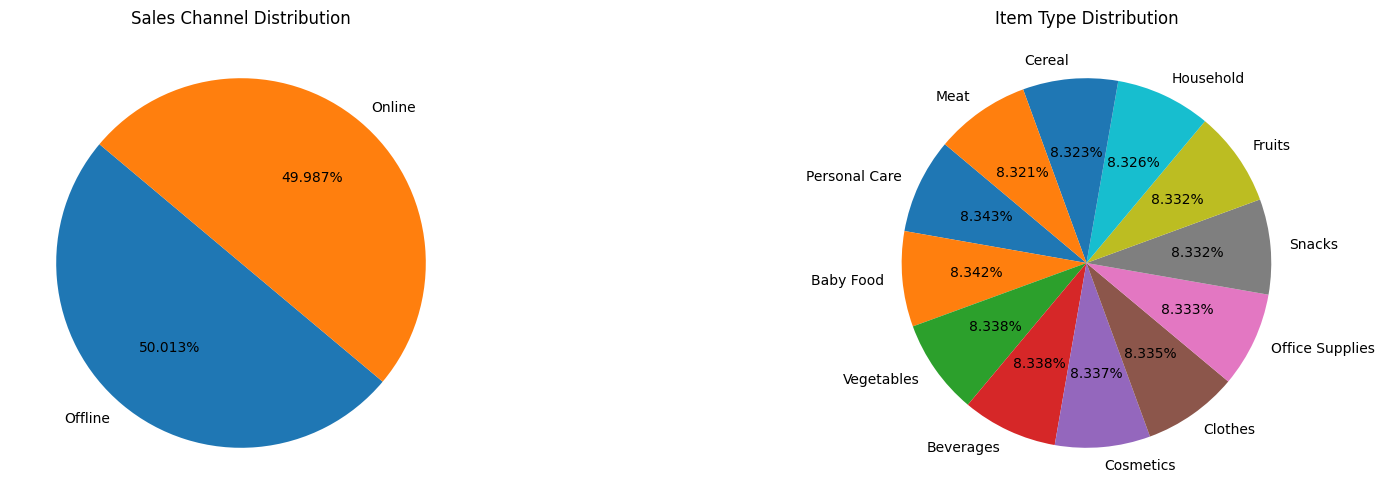

In [58]:
offline_sales = sales_data[sales_data['Sales Channel'] == 'Offline']
online_sales = sales_data[sales_data['Sales Channel'] == 'Online']
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.pie([len(offline_sales),len(online_sales)],labels=['Offline','Online'],autopct='%1.3f%%',startangle=140)
plt.title('Sales Channel Distribution')
plt.subplot(1,2,2)
plt.pie(sales_data['Item Type'].value_counts(),labels=sales_data['Item Type'].value_counts().index,autopct='%1.3f%%',startangle=140)
plt.title('Item Type Distribution')
plt.show()

After grouping wrt order month-year visualisation

In [59]:
sales_pre_groupData = sales_data[['Order Date','Total Revenue']].reset_index(drop=True)
sales_pre_groupData['year_month'] = sales_pre_groupData['Order Date'].dt.to_period('M').astype(str)
sales_groupData = sales_pre_groupData.groupby('year_month')['Total Revenue'].mean().reset_index()
sales_pre_groupData['year'] = sales_groupData['year_month'].str.split('-').str[0].astype(int)
print(sales_groupData)

    year_month  Total Revenue
0      2010-01   1.326795e+06
1      2010-02   1.321584e+06
2      2010-03   1.332171e+06
3      2010-04   1.328993e+06
4      2010-05   1.328826e+06
..         ...            ...
124    2020-05   1.339746e+06
125    2020-06   1.323534e+06
126    2020-07   1.328172e+06
127    2020-08   1.326754e+06
128    2020-09   1.355611e+06

[129 rows x 2 columns]


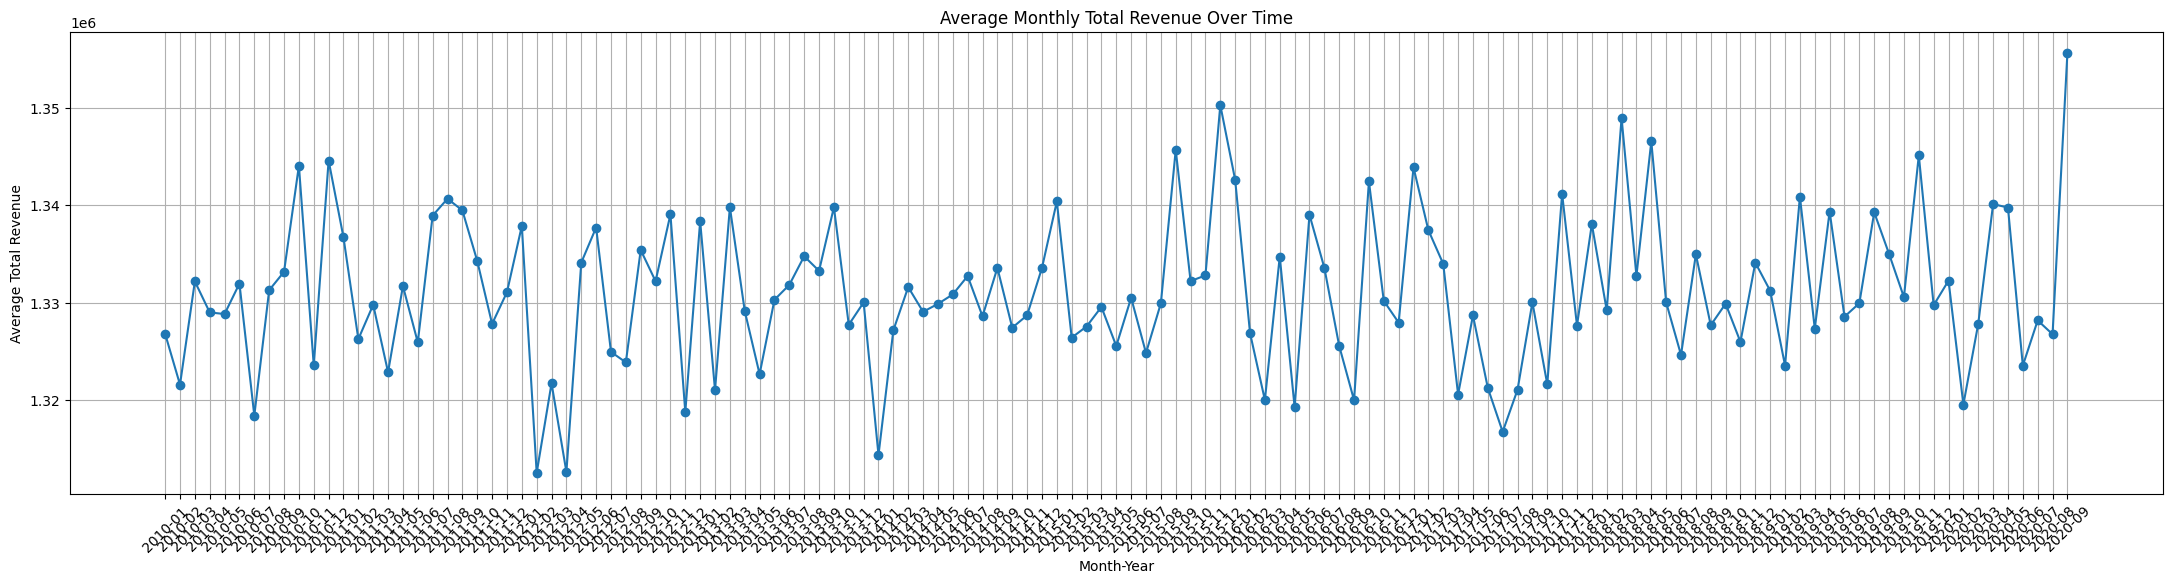

C:\Users\sande\AppData\Local\Temp\ipykernel_9324\2443777242.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=temp['Total Revenue'], x=temp['year'], palette='viridis')


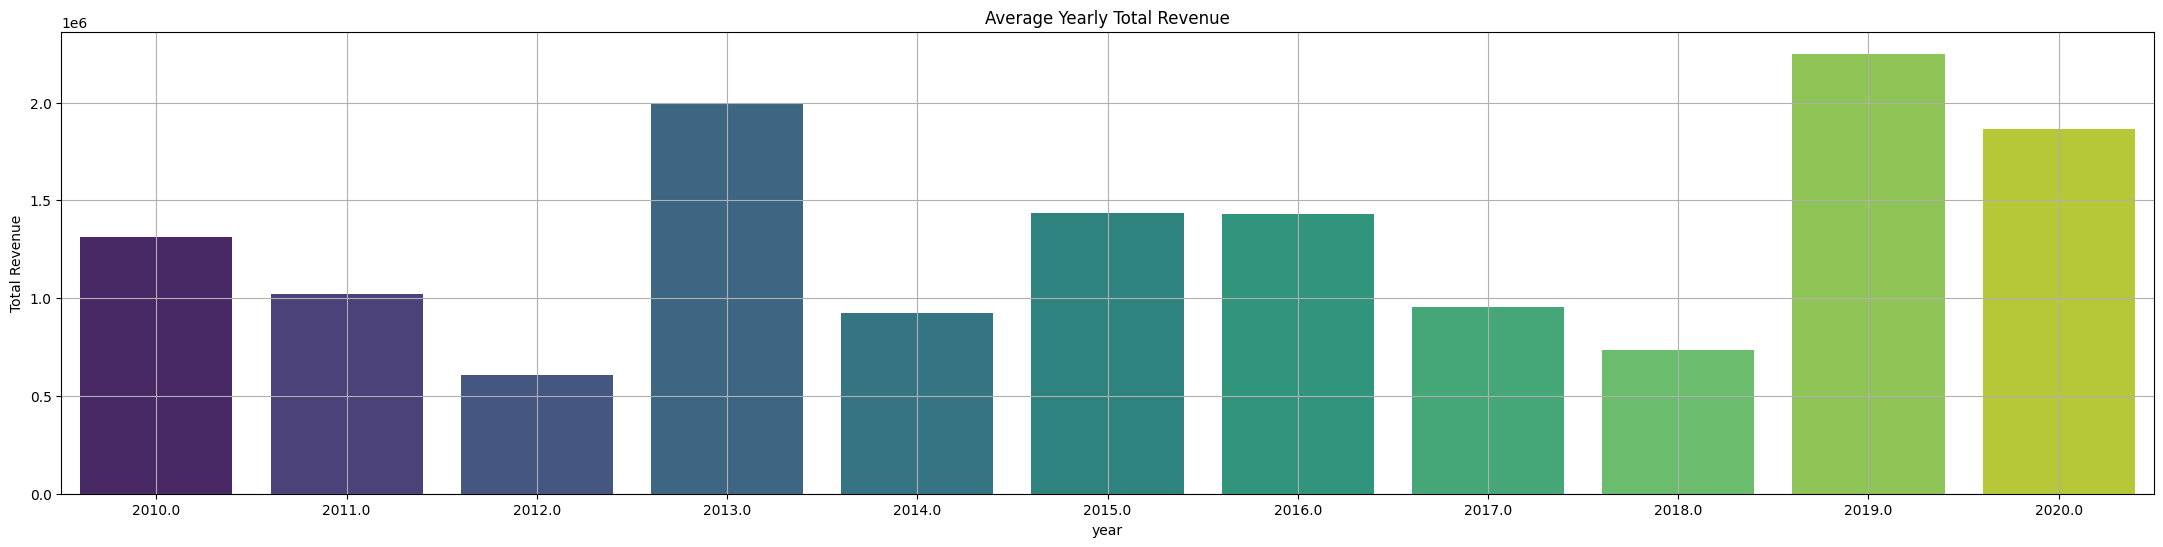

In [60]:
plt.figure(figsize=(27,6))
plt.plot(sales_groupData['year_month'], sales_groupData['Total Revenue'], marker='o')
plt.xticks(rotation=45)
plt.title('Average Monthly Total Revenue Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Total Revenue')
plt.grid()
plt.show()
plt.figure(figsize=(27,6))
temp = sales_pre_groupData.groupby('year')['Total Revenue'].mean().reset_index()
sns.barplot(y=temp['Total Revenue'], x=temp['year'], palette='viridis')
plt.title('Average Yearly Total Revenue')
plt.grid()
plt.show()

# Arima Model(p,d,q)
research paper - https://www.researchgate.net/publication/328633706_Forecasting_of_demand_using_ARIMA_model